In [1]:
import torch
from sklearn.model_selection import ShuffleSplit
import pennylane.numpy as np
from model_parameters import ModelParameters
import pennylane as qml
from tqdm.notebook import tqdm
import time

In [2]:
model_parameters = ModelParameters()
x_train, x_test, y_train, y_test = model_parameters.get_htru_2()

(<Figure size 3024x648 with 1 Axes>, <Axes:>)

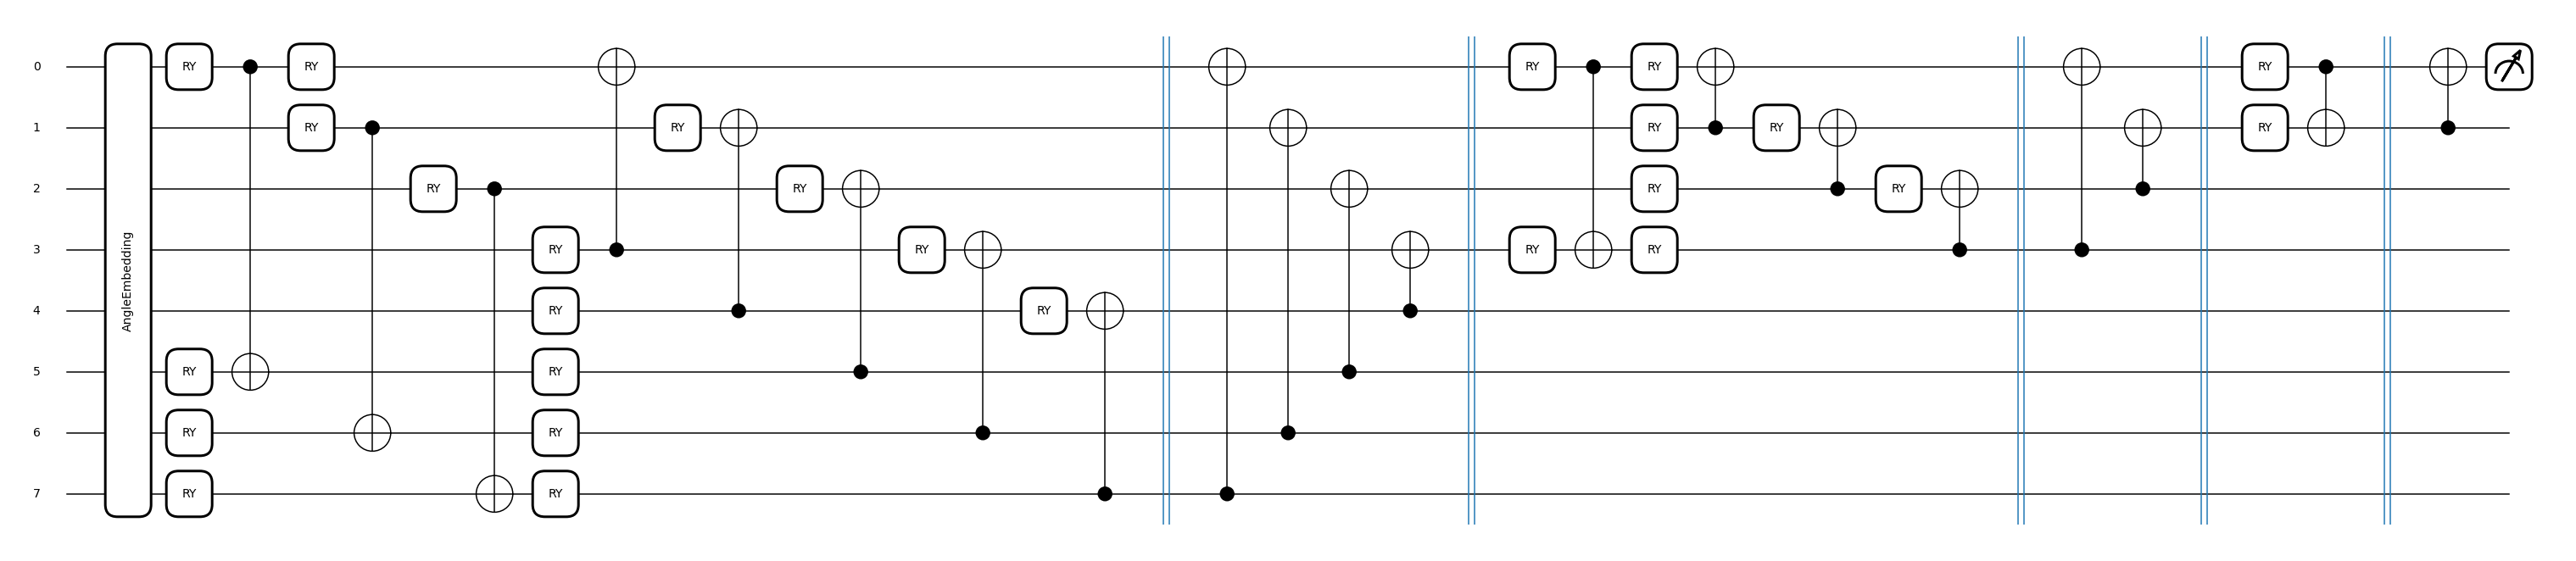

In [3]:
wires = range(8)

def conv(params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    
def conv_layer(params, stride, n_qubits):
    for i in range(n_qubits):
        conv(params[2*i:2*i+2], [wires[i], wires[(i+stride)%n_qubits]])



def pool_layer(n_qubits):
    for i in range(int(n_qubits/2)):
        qml.CNOT([n_qubits-i-1, i])


n_qubits = model_parameters.num_features
dev = qml.device("default.qubit", wires=n_qubits)

weight_shapes = {"weights_c1": 16, "weights_c2": 18, "weights_c3": 2}

@qml.qnode(dev)
def qnode(inputs, weights_c1, weights_c2, weights_c3):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    conv_layer(weights_c1, 5, 8)

    qml.Barrier()
    pool_layer(8)

    qml.Barrier()
    conv_layer(weights_c2, 3, 4)

    qml.Barrier()
    pool_layer(4)

    qml.Barrier()
    qml.RY(weights_c3[0], wires=0)
    qml.RY(weights_c3[1], wires=1)
    qml.CNOT([0,1])
    #conv_layer(weights_c3, 1, 2)

    qml.Barrier()
    pool_layer(2)


    return qml.expval(qml.PauliZ(0))


random_input = np.random.randn(8)
weights_c1 = np.random.randn(16)
weights_c2 = np.random.randn(8)
weights_c3 = np.random.randn(2)

qml.draw_mpl(qnode)(random_input, weights_c1, weights_c2, weights_c3)

In [4]:
class QuantumCNN(torch.nn.Module):
    def __init__(self):
        super(QuantumCNN, self).__init__()
        self.qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

    def forward(self, x):   
        x = self.qlayer(x)
        x = torch.sigmoid(x)
        return x


In [5]:
def train_network(model,optimizer,criterion,x_train,y_train,x_test,y_test,num_epochs,train_losses,test_losses):
    for epoch in range(num_epochs):
        #clear out the gradients from the last step loss.backward()
        optimizer.zero_grad()
        
        #forward feed
        output_train = model(x_train)

        #calculate the loss
        loss_train = criterion(output_train, y_train.float())
        
        #backward propagation: calculate gradients
        loss_train.backward()

        #update the weights
        optimizer.step()
        
        output_test = model(x_test)
        loss_test = criterion(output_test,y_test.float())

        train_losses[epoch] = loss_train.item()
        test_losses[epoch] = loss_test.item()

for i in tqdm(range(model_parameters.num_runs)):
    num_epochs = model_parameters.max_num_epochs
    train_losses = np.zeros(num_epochs)
    test_losses  = np.zeros(num_epochs)
    model = QuantumCNN()

    learning_rate = 0.01
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

    balanced_x_train, balanced_y_train = model_parameters.sub_select_dataset(x_train, y_train, model_parameters.training_samples, balanced=True)
    sub_selected_x_test, sub_selected_y_test = model_parameters.sub_select_dataset(x_test, y_test, model_parameters.testing_samples)

    balanced_x_train, sub_selected_x_test, balanced_y_train, sub_selected_y_test = model_parameters.torch_convertion(balanced_x_train, sub_selected_x_test, balanced_y_train, sub_selected_y_test)

    start_training_time = time.time()
    train_network(model,optimizer,criterion, balanced_x_train,balanced_y_train, sub_selected_x_test,sub_selected_y_test,num_epochs,train_losses,test_losses)
    end_training_time = time.time()

    training_duration = end_training_time - start_training_time

    # Predict the test set
    start_testing_time = time.time()
    output_test = model(sub_selected_x_test)
    end_testing_time = time.time()

    testing_duration = end_testing_time - start_testing_time

    predicted_test = (output_test > 0.5).float()

    # Calculate the scores
    model_parameters.append_score(sub_selected_y_test, predicted_test, training_duration, testing_duration)

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Print the scores
for metric, values in model_parameters.scores.items():
    mean_value = np.mean(values)
    std_value = np.std(values)
    print(f"{metric.capitalize()}: {mean_value:.3f} ± {std_value:.3f}")

Accuracy: 0.916 ± 0.016
Balanced_accuracy: 0.915 ± 0.037
Recall: 0.913 ± 0.081
Specificity: 0.917 ± 0.019
Precision: 0.509 ± 0.057
Npv: 0.990 ± 0.010
Gmean: 0.914 ± 0.037
Informedness: 0.831 ± 0.074
